In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_trajectories
import matplotlib.pyplot as plt
from example_utils import reject_outliers, initial_conditions, plot_phase_portrait

from MARBLE import utils, geometry, net, plotting, postprocessing, compare_attractors

/Users/gosztola/opt/anaconda3/envs/MARBLE/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simulate_system(mu, X0, t):
    p, v = simulate_trajectories('vanderpol', X0, t, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = reject_outliers(p_, v_)
        pos.append(p_[ind])
        vel.append(v_[ind])
        
    return pos, vel

def parabola(X, Y, alpha):
    Z = -(alpha*X)**2 -(alpha*Y)**2
    
    return np.column_stack([X.flatten(), Y.flatten(), Z.flatten()])

# For initial conditions, sample a rectangle uniformly

In [3]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [4]:
n_steps=10
beta1 = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), area)
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i], t)
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
#embed on cone
alpha = 0.1
for i, (p, v) in enumerate(zip(pos, vel)):
    end_point = p + v
    new_endpoint = parabola(end_point[:,0], end_point[:,1], alpha)
    pos[i] = parabola(p[:,0], p[:,1], alpha)
    vel[i] = new_endpoint - pos[i]

/Users/gosztola/opt/anaconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Plot vector fields

In [5]:
k=10

data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=k, stop_crit=0.04)

---- Embedding dimension: 3
---- Signal dimension: 3


Computing gauges...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.99it/s]



Fraction of variance explained:  tensor([0.5771, 1.0000, 1.0000])

---- Manifold dimension: 2

Manifold dimension can decrease with more data. Try smaller values of stop_crit                 before settling on a value


Computing connections...: 100%|█████████████████████████████████████████████████████████████████████████| 14553/14553 [00:11<00:00, 1308.66it/s]


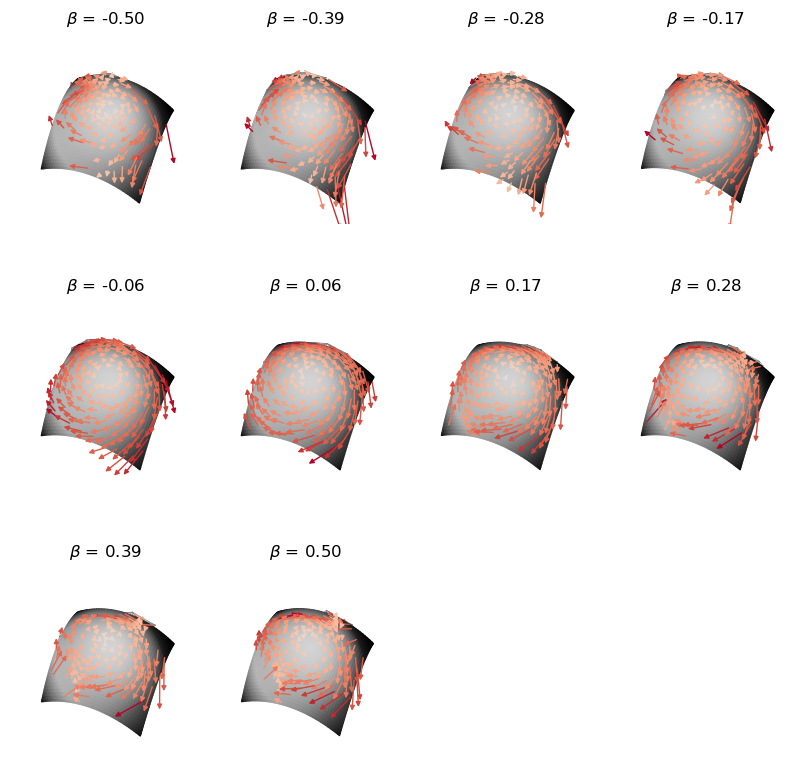

In [12]:
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]

#plotting.fields(data, col=4, alpha=0.3, scale=10)
axes = plotting.fields(data, col=4, alpha=1, width=7, scale=2, titles=titles, view=[70,20])

from matplotlib.colors import LightSource

x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
xyz = np.array(parabola(np.ravel(X), np.ravel(Y), alpha))
ls = LightSource(azdeg=30,altdeg=30)
rgb = ls.shade(xyz[:,2].reshape(X.shape)-0.1, plt.cm.gray)

for ax in axes:
    ax.plot_surface(xyz[:,0].reshape(X.shape), xyz[:,1].reshape(X.shape), xyz[:,2].reshape(X.shape)-0.02, 
                color='gray', 
                shade=True,
                lightsource=ls,
                facecolors=rgb
               )
plt.savefig('../results/parabolas.svg')

# Train network

In [23]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'epochs': 100, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
       'autoencoder': False,
      }

model = net(data, **par)
model.run_training(data)


---- Settings: 

epochs : 100
order : 2
hidden_channels : 16
out_channels : 3
inner_product_features : True
autoencoder : False
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  394

---- Training network ...

Epoch: 1, Training loss: 1.3828, Validation loss: 1.3810, lr: 0.0100 *
Epoch: 2, Training loss: 1.3806, Validation loss: 1.3795, lr: 0.0100 *
Epoch: 3, Training loss: 1.3771, Validation loss: 1.3762, lr: 0.0100 *
Epoch: 4, Training loss: 1.3742, Validation loss: 1.3692, lr: 0.0100 *
Epoch: 5, Training loss: 1.3649, Validation loss: 1.3606, lr: 0.0100 *
Epoch: 6, Training loss: 1.3518, Validation loss: 1.3581, lr: 0.0100 *
Epoch: 7, Training loss: 1.3187, Validation loss: 1.2772, lr: 0.0100 *
Epoch: 8, Training loss: 1.2787, 

# Create embeddings

Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.


<AxesSubplot:>

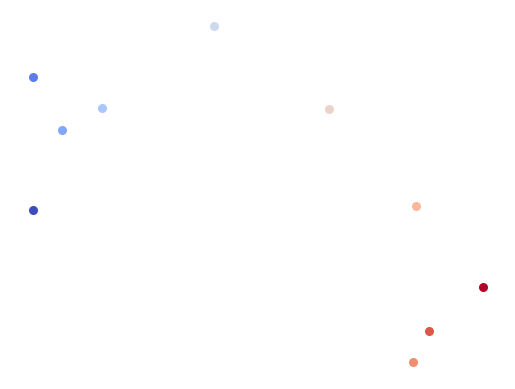

In [24]:
data = model.evaluate(data)
n_clusters=20
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1, s=30, alpha=1)

# Distance matrix

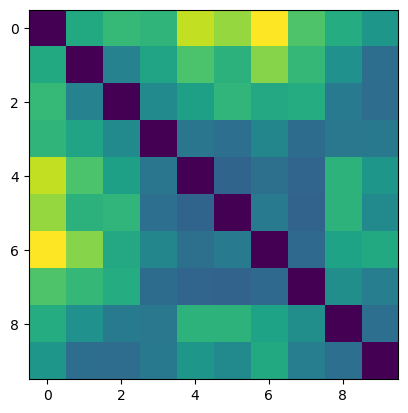

In [12]:
plt.imshow(data.dist)

# Cluster and visualise embedding

In [ ]:
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)

In [ ]:
compare_attractors(data, (4,5))

In [ ]:
n_clusters=[2,4,6,8]
fig, ax = plt.subplots(len(n_clusters),4, figsize=(10,10))
slices=data._slice_dict['x']

def plot_embedding(data, ax, slices, i, n_clusters=2):
    s = range(slices[i], slices[i+1])
    clusters = geometry.cluster(data.emb_2d, cluster_typ='kmeans', n_clusters=n_clusters, seed=0)
    plotting.embedding(data.emb_2d[s], clusters['labels'][s], ax=ax[0])
    plot_phase_portrait(data.pos[s], data.x[s], ax[1], node_feature=clusters['labels'][s])

snapshot=4
for i, n in enumerate(n_clusters):
    plot_embedding(data, ax[:,:2][i], slices, snapshot, n_clusters=n)
    
snapshot=5
for i, n in enumerate(n_clusters):
    plot_embedding(data, ax[:,2:][i], slices, snapshot, n_clusters=n)